In [1]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
nltk.data.path.append('.')

In [3]:
import re                                                          
with open('isl_input_vocab.txt') as f:
    data = f.read()                                                
data = re.sub(r'[,!?;-]', '.',data)                                 
data = nltk.word_tokenize(data)                                     
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    
print("Number of tokens:", len(data),'\n', data[:15])  

Number of tokens: 266 
 ['ï', 'name', 'j', 'o', 'h', 'n', 'hello', 'your', 'name', 'what', 'you', 'stay', 'where', 'you', 'age']


In [4]:
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) )

Size of vocabulary:  139
Most frequent tokens:  [('you', 24), ('i', 16), ('what', 10), ('your', 8), ('go', 7), ('where', 6), ('please', 6), ('good', 6), ('we', 5), ('name', 4), ('my', 4), ('when', 4), ('stay', 3), ('call', 3), ('me', 3), ('meet', 3), ('family', 3), ('book', 3), ('j', 2), ('o', 2)]


In [5]:
def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    word2Ind = {}
    Ind2Word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2Word[idx] = k
        idx += 1
    return word2Ind, Ind2Word

In [6]:
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  139


In [13]:
print("Index of the word 'Delhi' :  ",word2Ind['delhi'] )
print("Word which has index 23:  ",Ind2word[23] )

Index of the word 'Delhi' :   25
Word which has index 23:   come


In [14]:
def initialize_model(N, V, random_seed = 1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    np.random.seed(random_seed)

    W1 = np.random.random((N,V))
    W2 = np.random.random((V,N))
    b1 = np.random.random((N,1))
    b2 = np.random.random((V,1))

    return W1,W2,b1,b2

In [15]:
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


In [16]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
       
    yhat = np.exp(z)/np.sum(np.exp(z), axis = 0)
       
    return yhat

In [17]:
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

In [18]:
def forward_prop(x,W1,W2,b1,b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    h = np.dot(W1,x) + b1
    h = np.maximum(0,h)
    z = np.dot(W2,h) + b2
    return z,h

In [19]:
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


In [20]:
from scipy import linalg
from collections import defaultdict


def sigmoid(z):
    # sigmoid function
    return 1.0/(1.0+np.exp(-z))


def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx


def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed


def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0


def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []


def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    ### START CODE HERE ###
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    ### END CODE HERE ###
    return np.dot(evecs.T, data.T).T


In [21]:
def compute_cost(y, yhat, batch_size):
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [22]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (139, 4)
tmp_y.shape (139, 4)
tmp_W1.shape (50, 139)
tmp_W2.shape (139, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (139, 1)
tmp_z.shape: (139, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (139, 4)
call compute_cost
tmp_cost 10.8978


In [23]:
def back_prop(x, yhat,y,h,W1,W2,b1,b2, batch_size):
    l1 = np.dot(W2.T, (yhat - y))
    l1 = np.maximum(0,l1)
    grad_W1 = (1/batch_size) *np.dot(l1,x.T)
    grad_W2 = (1/batch_size)*np.dot(yhat-y, h.T)
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    return grad_W1, grad_W2, grad_b1, grad_b2

In [24]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (139, 4)
tmp_y.shape (139, 4)

Initialize weights and biases
tmp_W1.shape (50, 139)
tmp_W2.shape (139, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (139, 1)

Forwad prop to get z and h
tmp_z.shape: (139, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (139, 4)

call back_prop
tmp_grad_W1.shape (50, 139)
tmp_grad_W2.shape (139, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (139, 1)


In [28]:
def gradient_descent(data, word2Ind, N, V, num_iters , alpha = 0.03 ):
    W1, W2, b1, b2 = initialize_model(N,V, random_seed= 100)
    batch_size = 30
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###
        # Get z and h
        z, h = forward_prop(x,W1,W2,b1,b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y,yhat,batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
    
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        ### END CODE HERE ###
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2


In [29]:
C = 2
N = 30
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 200
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.165155
iters: 20 cost: 0.065762
iters: 30 cost: 0.041085
iters: 40 cost: 0.029888
iters: 50 cost: 0.023494
iters: 60 cost: 0.019357
iters: 70 cost: 0.016461
iters: 80 cost: 0.014321
iters: 90 cost: 0.012673
iters: 100 cost: 0.011367
iters: 110 cost: 0.010609
iters: 120 cost: 0.009977
iters: 130 cost: 0.009416
iters: 140 cost: 0.008915
iters: 150 cost: 0.008465
iters: 160 cost: 0.008058
iters: 170 cost: 0.007688
iters: 180 cost: 0.007351
iters: 190 cost: 0.007042
iters: 200 cost: 0.006758


In [42]:
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['i', 'you','morning','night', 'your','good','four',
         'go','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)

(10, 30) [53, 20, 69, 133, 136, 41, 37, 40, 43, 93]


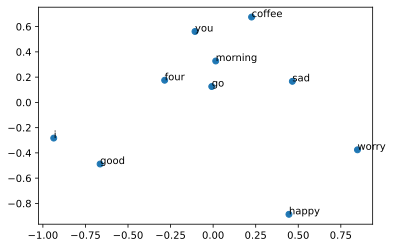

In [43]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

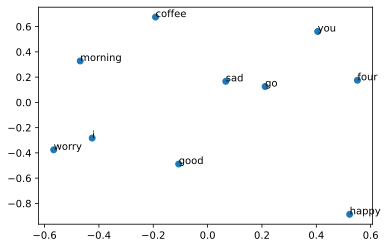

In [44]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()